In [302]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

### Import Data

In [2]:
data = pd.read_csv('./data/A17U-SI.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-10-31,1.514444,1.650356,1.514444,1.533860,0.625674,5103019
1,2008-11-03,1.630940,1.776559,1.630940,1.747436,0.712794,5438825
2,2008-11-04,1.698896,1.747436,1.630940,1.640648,0.669234,4405654
3,2008-11-05,1.679480,1.776559,1.660064,1.766851,0.720713,3008865
4,2008-11-06,1.601816,1.698896,1.572692,1.689188,0.689034,3841170


In [3]:
# Check for missing values
data.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [4]:
# Isolate Target Columns
df = data.loc[:, ['Date', 'Close']]
df.set_index('Date', inplace=True)

# Set to date-time index
df.index = pd.to_datetime(df.index)
df = df.asfreq('D')
df

,Close
Date,
2008-10-31,1.533860
2008-11-01,NaN
2008-11-02,NaN
2008-11-03,1.747436
2008-11-04,1.640648
...,...
2023-10-26,2.500000
2023-10-27,2.510000
2023-10-28,NaN


#### Handling Gaps in weekends

In [5]:
# Default option: use last observed data point
df.fillna(method='ffill', inplace=True)

<AxesSubplot:title={'center':'A17U.SI Time Series'}, xlabel='Date'>

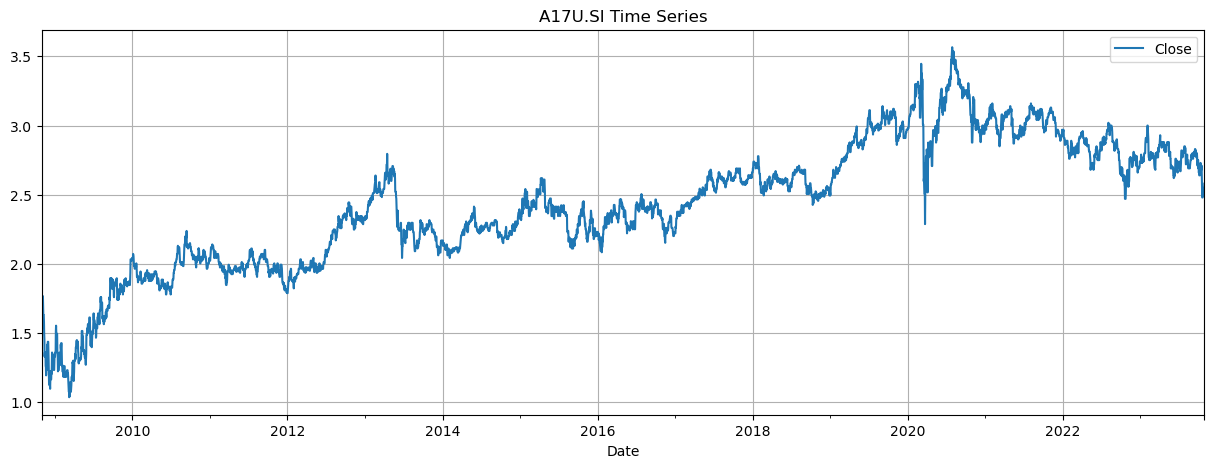

In [6]:
df.plot(title='A17U.SI Time Series',figsize=(15,5), grid=True)

In [7]:
# Convert 
# df.diff().plot(title='First Order Differencing',figsize=(15,5), grid=True, color='purple')

### Fuzzy Time Series

In [359]:
from pyFTS.partitioners import Grid, partitioner
from pyFTS.common import FLR
from pyFTS.models import chen, cheng
from pyFTS.common import Util
from pyFTS.common import Transformations

from scipy.optimize import fsolve
import numpy as np
import fuzzylab as fz
from fuzzylab.evalmf import evalmf

from collections import defaultdict

In [376]:
# Data Partitioning and MF generation
n_partitions = 120

train = df.values.reshape(-1,)[:-365]
test = df.values.reshape(-1,)[-365:]
test_lagged = df.values.reshape(-1,)[-366:-1]

In [377]:
# Apply Differencing to make data stationary
#train = diff.apply(train)

#### Self Implementation

In [378]:
class fuzzymf(object):
    def __init__(self, Type, Parameters):
        self.Type = Type
        self.Parameters = Parameters
    def __repr__(self):
            return 'fismf, '\
                ' Type: %s, '\
                ' Parameters: %s\n'\
                % (self.Type,self.Parameters)

In [379]:
# DEFAULT: Evenly spaced across universe of discourse
def get_centroids(x, n_partitions, PAD_RATIO = 0.02):
    
    val_range = max(x) - min(x)
    min_val = min(x) - (val_range * PAD_RATIO)
    max_val = max(x) + (val_range * PAD_RATIO)
    
    #pad_min, pad_max = (min(x) - partition_len * max(x), max(x) * (1 + partition_len))

    # Evenly Spaced
    centroids, partition_len = np.linspace(min_val, max_val, n_partitions+1, endpoint = False, retstep=True)
    centroids = centroids[1:]
    
    return centroids, (min_val, max_val, partition_len)

In [380]:
def span_learnmf(x, n_partitions):
    
    centroids, (min_val, max_val, partition_len) = get_centroids(x, n_partitions)
    
    mf={}
    for idx, centroid in enumerate(centroids):
        mf[idx] = fuzzymf(Type = 'trimf', Parameters = [centroid-partition_len, centroid, centroid+partition_len])
            
    return mf, (min_val, max_val, partition_len), centroids

In [381]:
fuzzy_set, (min_val, max_val, partition_len), centroids = span_learnmf(train, n_partitions)
fuzzy_set

{0: fismf,  Type: trimf,  Parameters: [0.9854135400000001, 1.0071609112396696, 1.028908282479339],
 1: fismf,  Type: trimf,  Parameters: [1.0071609112396696, 1.028908282479339, 1.0506556537190084],
 2: fismf,  Type: trimf,  Parameters: [1.028908282479339, 1.0506556537190084, 1.0724030249586778],
 3: fismf,  Type: trimf,  Parameters: [1.0506556537190084, 1.0724030249586778, 1.0941503961983472],
 4: fismf,  Type: trimf,  Parameters: [1.0724030249586778, 1.0941503961983472, 1.1158977674380166],
 5: fismf,  Type: trimf,  Parameters: [1.0941503961983472, 1.1158977674380166, 1.137645138677686],
 6: fismf,  Type: trimf,  Parameters: [1.1158977674380168, 1.1376451386776862, 1.1593925099173557],
 7: fismf,  Type: trimf,  Parameters: [1.137645138677686, 1.1593925099173554, 1.1811398811570248],
 8: fismf,  Type: trimf,  Parameters: [1.1593925099173557, 1.181139881157025, 1.2028872523966945],
 9: fismf,  Type: trimf,  Parameters: [1.181139881157025, 1.2028872523966945, 1.2246346236363639],
 10: fi

(0.9854135400000001, 3.6168454600000004)


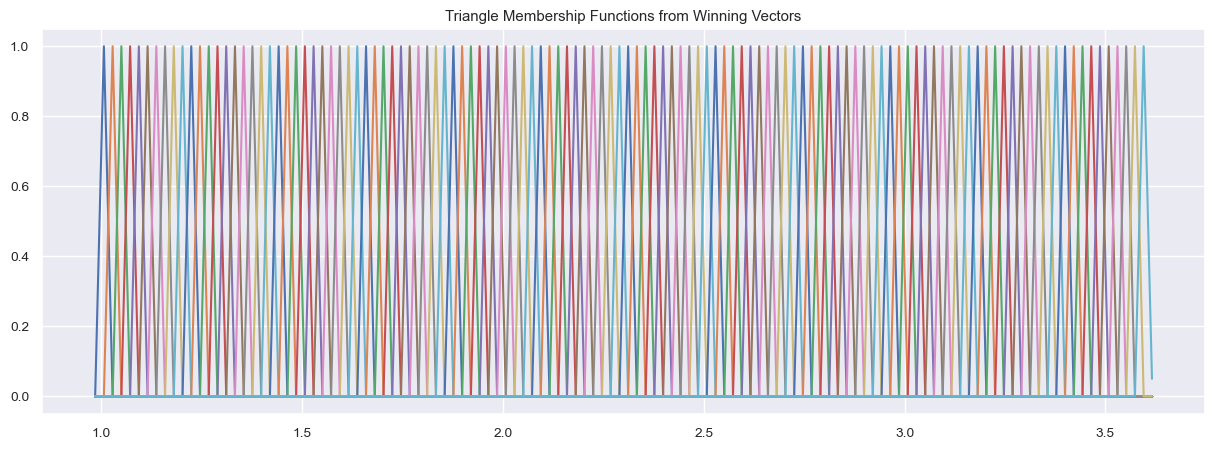

In [382]:
print((min_val, max_val))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,5])
for i in range(len(fuzzy_set)):
    x = np.linspace(min_val, max_val, (n_partitions+1)*20, endpoint = False)
    ax.plot(x, evalmf(fuzzy_set[i], x), label='Winning Vector 1')
    ax.set_title("Triangle Membership Functions from Winning Vectors")

plt.show()

In [383]:
def get_membership(input_value, fuzzy_set=fuzzy_set, prefix='A'):
    membership_keys = [key for key, value in fuzzy_set.items() if value.Parameters[0] <= input_value <= value.Parameters[-1]]
    membership_vals = [evalmf(fuzzy_set[key], input_value)[0] for key in membership_keys]
    membership_index = membership_keys[np.argmax(membership_vals)]
    return prefix+str(membership_index), membership_index

In [384]:
## FUZZIFICATION
fuzzified_lv = []
fuzzified_val = []

for crisp_val in train:
    ling_var, val = get_membership(crisp_val)
    fuzzified_lv.append(ling_var)
    fuzzified_val.append(val)

In [385]:
## Fuzzy Logical Relationship Groups (FLRG)
fuzzified_lv_lag = fuzzified_lv[:-1]
fuzzified_lv_lead = fuzzified_lv[1:]

fuzzified_lag = fuzzified_val[:-1]
fuzzified_lead = fuzzified_val[1:]

#pd.DataFrame([fuzzified_lv_lag, fuzzified_lv_lead], index=['lag', 'lead']).transpose()

# FLRG Index Values
flrg_vals = [(i,j) for i,j in zip(fuzzified_lag, fuzzified_lead)]

# Display Sequential FLRG
flrg_lv = [i + '->' + j for i,j in zip(fuzzified_lv_lag, fuzzified_lv_lead)]
flrg_lv

['A24->A24',
 'A24->A24',
 'A24->A34',
 'A34->A29',
 'A29->A35',
 'A35->A31',
 'A31->A29',
 'A29->A29',
 'A29->A29',
 'A29->A26',
 'A26->A22',
 'A22->A21',
 'A21->A15',
 'A15->A16',
 'A16->A16',
 'A16->A16',
 'A16->A16',
 'A16->A12',
 'A12->A12',
 'A12->A9',
 'A9->A10',
 'A10->A10',
 'A10->A10',
 'A10->A10',
 'A10->A14',
 'A14->A19',
 'A19->A16',
 'A16->A20',
 'A20->A20',
 'A20->A20',
 'A20->A17',
 'A17->A14',
 'A14->A9',
 'A9->A5',
 'A5->A5',
 'A5->A5',
 'A5->A5',
 'A5->A5',
 'A5->A4',
 'A4->A8',
 'A8->A10',
 'A10->A7',
 'A7->A7',
 'A7->A7',
 'A7->A10',
 'A10->A9',
 'A9->A12',
 'A12->A16',
 'A16->A15',
 'A15->A15',
 'A15->A15',
 'A15->A14',
 'A14->A11',
 'A11->A11',
 'A11->A11',
 'A11->A10',
 'A10->A10',
 'A10->A10',
 'A10->A13',
 'A13->A16',
 'A16->A15',
 'A15->A15',
 'A15->A16',
 'A16->A16',
 'A16->A16',
 'A16->A23',
 'A23->A25',
 'A25->A23',
 'A23->A21',
 'A21->A22',
 'A22->A22',
 'A22->A22',
 'A22->A17',
 'A17->A16',
 'A16->A14',
 'A14->A10',
 'A10->A10',
 'A10->A10',
 'A10->A10',

In [386]:
flrg_df = pd.DataFrame(flrg_vals, columns=['lag', 'lead'])
flrg_transitions = flrg_df.groupby(['lag', 'lead'])['lead'].count()

print('FTS Model:')
for i in range(n_partitions):
    try:
        flrg_transition_leads = list(flrg_transitions[i].index)
        flrg_transition_counts = list(flrg_transitions[i].values)
        
        transitions = [f'A{lead_idx}({flrg_transition_counts[j]})' for j, lead_idx in enumerate(flrg_transition_leads)]
        print(f'A{i} -> {" ".join(transitions)}')
        
    except:
        pass

FTS Model:
A1 -> A4(1)
A2 -> A6(1)
A3 -> A1(1) A3(2) A4(1)
A4 -> A2(1) A4(1) A5(1) A8(1)
A5 -> A3(1) A4(1) A5(4) A8(1)
A6 -> A3(1) A5(1) A6(2)
A7 -> A7(2) A9(1) A10(1)
A8 -> A6(1) A8(4) A9(4) A10(1)
A9 -> A5(1) A8(3) A9(3) A10(4) A12(1) A13(1)
A10 -> A7(1) A8(1) A9(3) A10(16) A12(2) A13(2) A14(1)
A11 -> A10(1) A11(2)
A12 -> A9(1) A10(2) A12(8) A13(1) A14(1) A16(1) A19(1)
A13 -> A7(1) A12(1) A13(9) A14(2) A16(3)
A14 -> A9(1) A10(1) A11(1) A13(2) A14(9) A15(2) A16(1) A19(1)
A15 -> A14(2) A15(3) A16(2) A18(2)
A16 -> A12(3) A13(1) A14(2) A15(2) A16(5) A17(1) A20(1) A22(1) A23(1)
A17 -> A14(1) A15(1) A16(3) A17(4)
A18 -> A18(4) A19(2) A20(4) A23(1)
A19 -> A16(2) A18(1) A19(2) A21(1)
A20 -> A17(3) A18(3) A20(6) A21(1) A22(1)
A21 -> A15(1) A18(1) A22(2) A23(1)
A22 -> A17(1) A20(2) A21(1) A22(4) A23(1) A24(1) A25(2)
A23 -> A20(1) A21(1) A22(1) A23(5) A24(2) A25(1)
A24 -> A21(1) A22(2) A24(7) A26(2) A28(2) A34(1)
A25 -> A23(1) A24(1) A26(2)
A26 -> A22(1) A23(1) A24(2) A25(1) A26(7) A27(1) A28(1

In [387]:
## Calculate Transition Count Matrix

# Identify unique states
states = list(np.arange(n_partitions))

# Create a default dictionary to hold counts
transition_counts = defaultdict(int)

# Traverse the list and increment count in the dictionary
for (i,j) in flrg_vals:
    transition_counts[(i,j)] += 1

# Create an empty matrix of size n x n
n = len(states)
count_matrix = np.zeros((n,n))

# Fill the transition matrix with counts from the dictionary
for key, val in transition_counts.items():
    i, j = key
    count_matrix[states.index(i)][states.index(j)] = val
    
row_sum = count_matrix.sum(axis=1)
probability_matrix = count_matrix/row_sum[:, None]

state_names = ['A'+str(i) for i in states]

transition_count_df = pd.DataFrame(count_matrix, columns=state_names, index=state_names)
markov_transition_prob_df = pd.DataFrame(probability_matrix, columns=state_names, index=state_names).fillna(0)

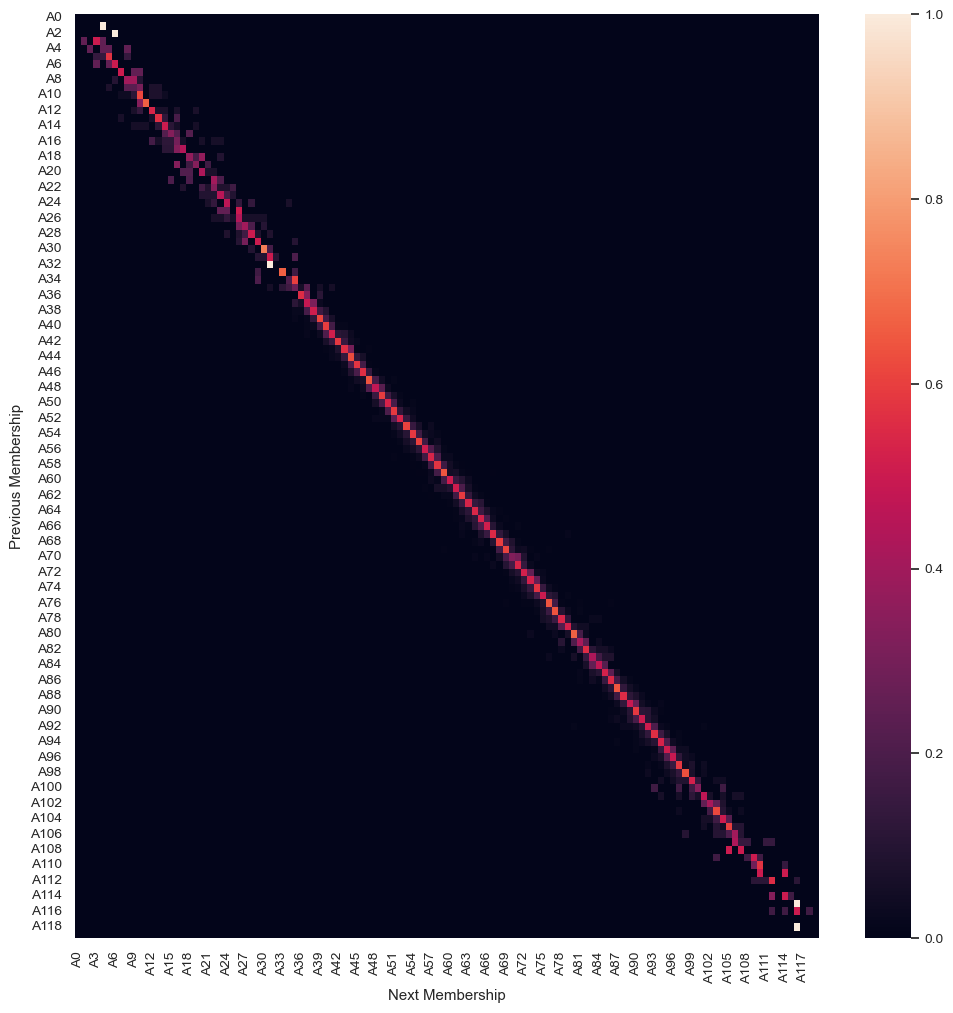

In [389]:
plt.figure(figsize=(12,12))
sns.heatmap(markov_transition_prob_df, annot=False, fmt='0.2f', annot_kws={"fontsize":8})
plt.xlabel('Next Membership')
plt.ylabel('Previous Membership')
plt.show()

In [407]:
## DEFUZZIFICATION
def get_point_forecast(point_value, centroids, prob_matrix):
    
    centroid_vector = centroids.copy()
    
    _, point_val = get_membership(point_value)
    
    prob_vector = prob_matrix[point_val]
    centroid_vector[point_val] = point_value
    
#     print(point_value)
#     print(centroid_vector)
#     print(prob_vector)
#     print(centroid_vector * prob_vector)
    
    point_forecast = np.dot(centroid_vector,prob_vector)
    _, point_val_next = get_membership(point_forecast)
    point_forecast += point_val_next - point_val
    
    return point_forecast

In [408]:
get_point_forecast(1.5875366538825197, centroids, markov_transition_prob_df.values)

1.5959680966273881

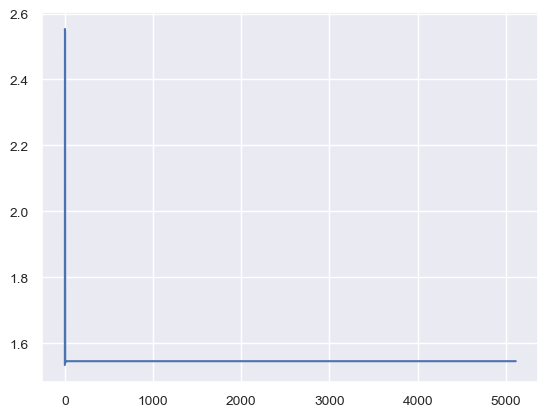

In [409]:
point_value = train[0]
forecasts = [point_value]

for _ in range(len(train) - 1):
    point_value = get_point_forecast(point_value, centroids, markov_transition_prob_df.values)
    forecasts.append(point_value)
    
plt.plot(forecasts)

In [348]:
"""
TO DO: Solve Convergence Problem
"""

'\nTO DO: Solve Convergence Problem\n'

#### Reference

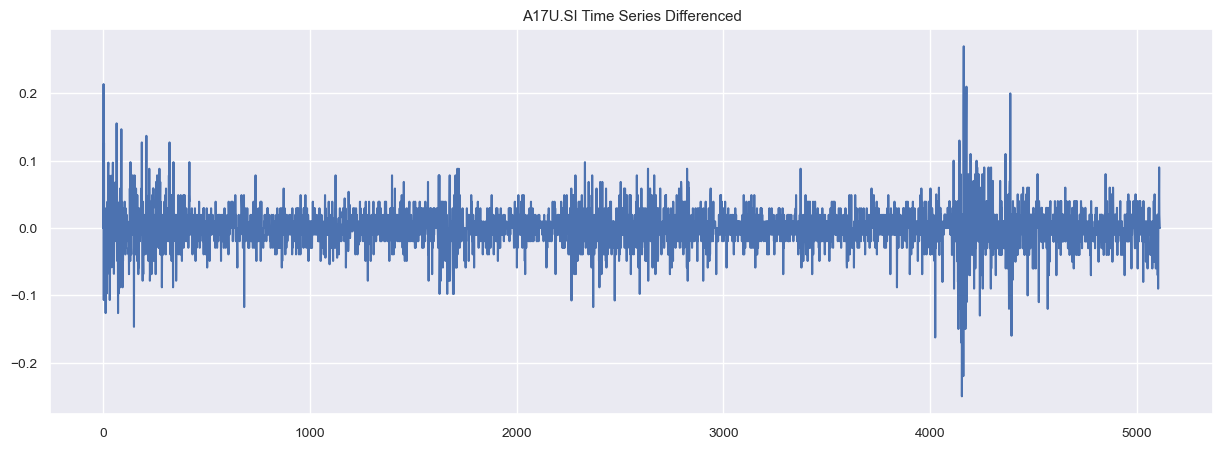

In [349]:
# Convert to Stationary Form
train_diff = pd.DataFrame(train).diff().values.reshape(-1,)[1:] 

plt.figure(figsize=(15,5))
plt.plot(train_diff)
plt.grid('True')
plt.title('A17U.SI Time Series Differenced')
plt.show()

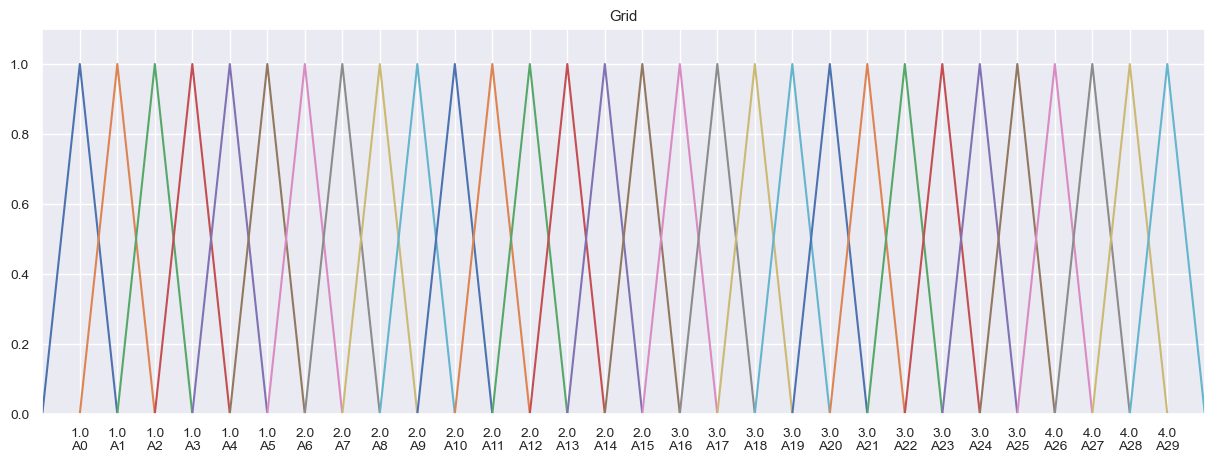

In [350]:
#n_partitions = 20
fs = Grid.GridPartitioner(data=train, npart=n_partitions)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,5])
fs.plot(ax)

In [ ]:
# # Fuzzification
# fuzzyfied = fs.fuzzyfy(train, method='maximum', mode='sets')

# # Generate Temporal Patterns
# patterns = FLR.generate_non_recurrent_flrs(fuzzyfied)

# #print([str(k) for k in patterns])
# #fuzzyfied

In [356]:
# Rule Generation
model = chen.ConventionalFTS(partitioner=fs)
#model = cheng.TrendWeightedFTS(partitioner=fs)
model.fit(train)
print(model)

Conventional FTS:
A1 -> A1,A2
A2 -> A1,A2,A3
A3 -> A2,A3,A4,A5
A4 -> A2,A3,A4,A5,A6
A5 -> A4,A5,A6
A6 -> A4,A5,A6,A7,A8
A7 -> A6,A7,A8
A8 -> A10,A7,A8,A9
A9 -> A10,A8,A9
A10 -> A10,A11,A9
A11 -> A10,A11,A12
A12 -> A11,A12,A13
A13 -> A12,A13,A14
A14 -> A13,A14,A15
A16 -> A14,A15,A16,A17
A15 -> A14,A15,A16,A18
A17 -> A16,A17,A18,A19,A20
A18 -> A17,A18,A19
A19 -> A17,A18,A19,A20
A20 -> A18,A19,A20,A21
A21 -> A18,A20,A21,A22,A23
A22 -> A20,A21,A22,A23
A23 -> A21,A22,A23,A24
A24 -> A22,A23,A24,A25
A25 -> A23,A24,A25,A26
A26 -> A25,A26



In [357]:
# Util.plot_rules(model, size=[25,10] , rules_by_axis=n_partitions)

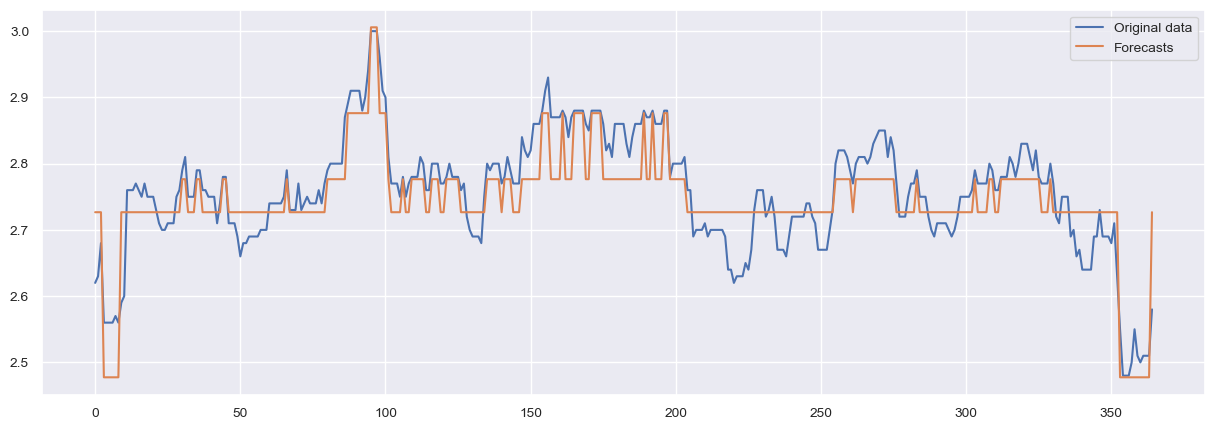

In [358]:
# Predict and Plot Results
test_diff = pd.DataFrame(test).diff().values.reshape(-1,)[1:]

##
forecasts = model.predict(test)
##


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,5])
orig, = plt.plot(test, label="Original data",)
pred, = plt.plot(forecasts, label="Forecasts")

plt.legend(handles=[orig, pred])

#### Testing effect of Stationarity

In [ ]:
# steps_ahead = 364

# inc = [forecasts[0] + test_lagged[0]]
# for t in np.arange(1, steps_ahead):
#     inc.append(forecasts[t] + inc[t-1])
    
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,5])
# orig, = plt.plot(test, label="Original data",)
# pred, = plt.plot(inc, label="Forecasted")

# plt.legend(handles=[orig, pred])

In [ ]:
# steps_ahead = 365

# inc = [forecasts[0] + test_lagged[0]]
# for t in np.arange(1, steps_ahead):
#     inc.append(forecasts[t] + inc[t-1])
    
# plt.plot(inc)

In [ ]:
# # Predict and Plot Results (FOR STATIONARY INPUT)
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,5])

# ##
# forecasts = model.predict(test_data_transform)
# #forecasts = [forecasts[t] + test_lagged[t] for t in np.arange(0, n)] ## <---???
# ##

# orig, = plt.plot(diff.apply(test), label="Original data (Diff)")
# pred, = plt.plot(forecasts, label="Forecasts")

# plt.legend(handles=[orig, pred])

In [ ]:
# # CODE FROM PYFTS
# train = df.values.reshape(-1,)[:-365]
# test = df.values.reshape(-1,)[-365:]

# diff = Transformations.Differential(1)

# part1 = Grid.GridPartitioner(data=train, npart=15, transformation=diff)
# part2 = Grid.GridPartitioner(data=train, npart=15)

# model1 = chen.ConventionalFTS(partitioner=part1)
# model1.append_transformation(diff)
# model1.fit(train)

# model2 = chen.ConventionalFTS(partitioner=part2)
# model2.fit(train)

# forecasts1 = model1.predict(test)
# forecasts2 = model2.predict(test)

# fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

# ax.plot(test, 'b', label='Original')
# ax.plot(forecasts1, 'r', label='With transformation')
# #ax.plot(forecasts2, label='Without transformation')

# handles, labels = ax.get_legend_handles_labels()
# lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

In [ ]:
"""
DONE:
1. Boilerplate code for Fuzzy Time Series Prediction that works
2. Found out a major issue in the predict method of the PyFTS class
3. Figure out how differencing transformation is applied and how model works internally
3.1 Probably no need to use differencing

TO DO:
1. Manual implementation of fuzzy partitioning
2. C-means implementation to optimize the number of partitions parameter
"""